In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mplcursors import cursor
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
from OpenAIService import OpenAIService
from tqdm import tqdm
import random
import json
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

openai_service = OpenAIService()

In [2]:
LOCATION = 'data'
LOCATION_PROCESSED = 'data_processed'
ALL_COMMENTS_FILENAME = f"{LOCATION_PROCESSED}/all_comments_embeddings.jsonl"
METRIC = 'euclidean'

In [3]:
# set random seed
random.seed(42)

# sampling
N_SAMPLES = 10_000

print("Counting lines of input file to get n...")
with open(ALL_COMMENTS_FILENAME, 'r') as lines:
    n = len(lines.readlines())
print(f"Data loaded. n={n}")

sample_prob = N_SAMPLES / n
# sample_prob = 1

row_samples = []

print(f"Sampling {N_SAMPLES} rows from {n} rows points with probability {sample_prob}...")
with open(ALL_COMMENTS_FILENAME, 'r') as lines:
    for line in tqdm(lines, total=n):
        if random.random() <= sample_prob:
            row = json.loads(line)
            row_samples.append(row)
print("Data sampled. Sampled data length:", len(row_samples))
print("Converting to DataFrame...")
df = pd.DataFrame(row_samples)
df.index = range(len(df))
print("Number of comments after sampling:", len(df))
print("Embeddings length:",len(row_samples[0]["embedding"]))

Counting lines of input file to get n...
Data loaded. n=50203
Sampling 10000 rows from 50203 rows points with probability 0.19919128338943887...


100%|██████████| 50203/50203 [00:01<00:00, 42242.23it/s]


Data sampled. Sampled data length: 10005
Converting to DataFrame...
Number of comments after sampling: 10005
Embeddings length: 384


In [4]:
# loading the embeddings
embeddings = np.array(df['embedding'].tolist())
print(embeddings.shape)

# print statistics
print("Embeddings statistics:")
print("Mean:", np.mean(embeddings))
print("Std:", np.std(embeddings))
print("Var:", np.var(embeddings))

# # use only first 2 dimensions
# embeddings = embeddings[:, :3]

# normalizing the embeddings
# scaler = StandardScaler()
# embeddings = scaler.fit_transform(embeddings)
# df['embedding'] = [e for e in embeddings]

# print("Embeddings statistics after normalization:")
# print("Mean:", np.mean(embeddings))
# print("Std:", np.std(embeddings))
# print("Var:", np.var(embeddings))

(10005, 384)
Embeddings statistics:
Mean: 9.871415134073052e-05
Std: 0.0510309408074661
Var: 0.0026041569196951085


In [5]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, metric=METRIC)
embeddings_2d = reducer.fit_transform(embeddings)

# tsne
# tsne = TSNE(n_components=2, random_state=42, perplexity=50, metric=METRIC)
# embeddings_2d = tsne.fit_transform(embeddings)


/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
agg_method = 'ward' if METRIC=='euclidean' else 'average'

# dendrogram
def plot_dendrogram(data, method=agg_method, metric=METRIC, filename=None):
    # calculate the linkage matrix
    Z = linkage(data, method=method, metric=metric)
    plt.figure(figsize=(10, 8))
    plt.title("Dendrogram of Comment Embeddings", fontsize=16)

    dendrogram(Z, )
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])

    # save the dendrogram if filename is provided
    if filename:
        plt.savefig(filename)

    plt.show()
    return Z

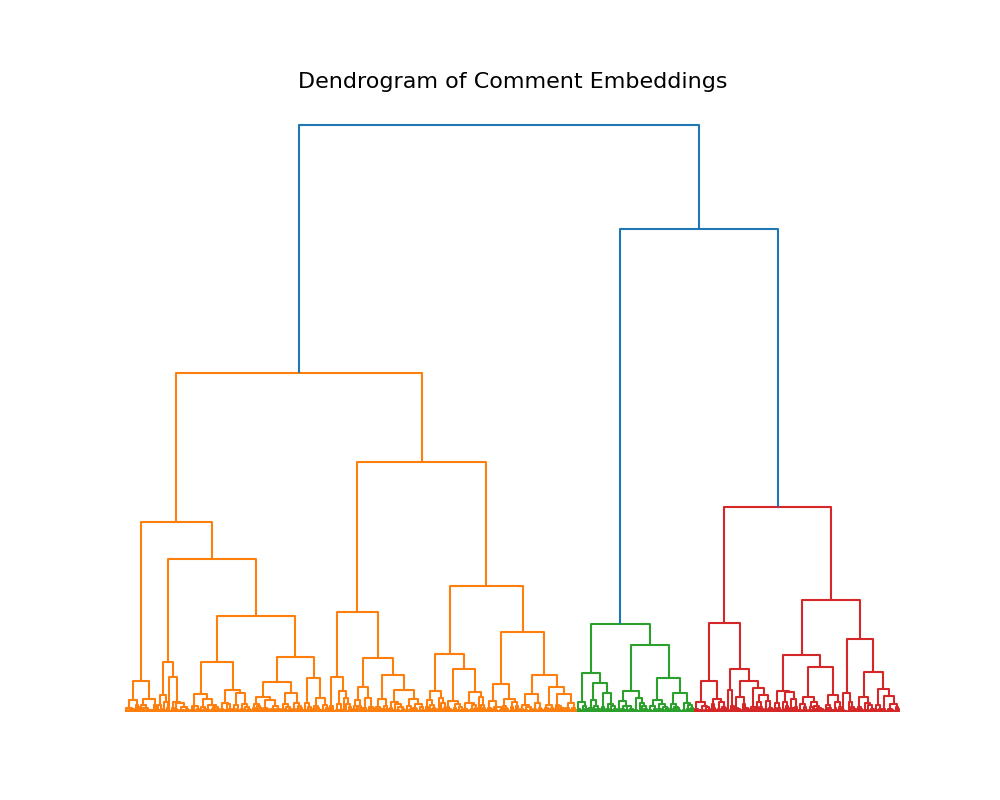

array([[7.36800000e+03, 7.37300000e+03, 5.84271061e-04, 2.00000000e+00],
       [6.03400000e+03, 6.31800000e+03, 5.94451296e-04, 2.00000000e+00],
       [1.61200000e+03, 5.29600000e+03, 6.34226583e-04, 2.00000000e+00],
       ...,
       [2.00030000e+04, 2.00050000e+04, 1.47600354e+02, 5.83200000e+03],
       [1.99960000e+04, 2.00040000e+04, 2.10333908e+02, 4.17300000e+03],
       [2.00060000e+04, 2.00070000e+04, 2.55432857e+02, 1.00050000e+04]])

In [7]:
plot_dendrogram(embeddings_2d, filename=f"{LOCATION_PROCESSED}/dendrogram_comments.png")

In [8]:
# elbow method
def plot_elbow(data, max_clusters=10, clusters=1):
    intertias = []
    for i in range(1, max_clusters):
        km = KMeans(n_clusters=i, random_state=0)
        km.fit(data)
        intertia = km.inertia_
        intertias.append(intertia)
    fig, ax = plt.subplots()
    ax.plot(range(1, max_clusters), intertias, marker='x', c='g')
    # horizontal line up to the y value
    ax.axvline(clusters, c='r', linestyle='--')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Inertia (WCSS)')
    ax.set_title('Elbow Method for finding Optimal K Comment Clusters')
    #tight layout
    plt.tight_layout()
    # save the plot
    plt.savefig(f"{LOCATION_PROCESSED}/elbow_comments.png", dpi=500)
    plt.show()

/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

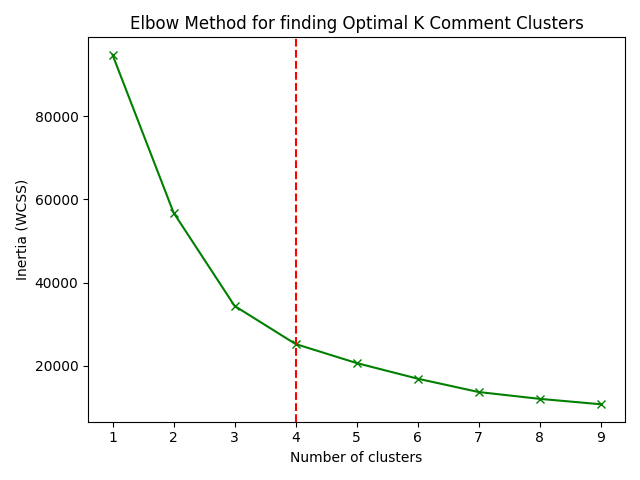

/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
CLUSTERS = 4
plot_elbow(embeddings_2d, max_clusters=10, clusters=CLUSTERS)

kmeans = KMeans(n_clusters=CLUSTERS, random_state=0)
kmeans.fit(embeddings_2d)
df['cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# clustering = AgglomerativeClustering(n_clusters=CLUSTERS, metric=METRIC, linkage=agg_method)
# agg_clusters = clustering.fit_predict(embeddings)
# df['cluster'] = agg_clusters

In [10]:
N_ITERATIONS = 10
N_SAMPLES = 2

cluster_theme_lists = {}

embeddings_2d_copy = embeddings_2d.copy()
df_copy = df.copy()

for iter in range(N_ITERATIONS):
    cluster_samples = {}
    # sample body N_SAMPLES times from each cluster
    for cluster in range(CLUSTERS):
        if cluster not in cluster_theme_lists:
            cluster_theme_lists[cluster] = []

        # find centeriod of the cluster
        cluster_center = cluster_centers[cluster]
        # sample N_SAMPLES close to the centeriod
        samples = []
        for i in range(N_SAMPLES):
            # find the closest point to the centeriod
            closest_point = np.argmin(np.linalg.norm(embeddings_2d_copy - cluster_center, axis=1))
            samples.append(df_copy.iloc[closest_point]['body'])
            # remove the closest point from the embeddings
            embeddings_2d_copy = np.delete(embeddings_2d_copy, closest_point, axis=0)
            df_copy = df_copy.drop(index=closest_point)
        

        # samples = df[df['cluster'] == cluster].sample(N_SAMPLES)["body"].tolist()
        cluster_samples[cluster] = samples

    cluster_themes_iter = openai_service.find_distinctive_themes_from_cluster_samples(cluster_samples)

    print(cluster_themes_iter)

    for cluster in cluster_themes_iter.keys():
        # print(cluster, cluster_themes_iter[cluster])
        cluster_theme_lists[int(cluster)].append(cluster_themes_iter[cluster])

{0: 'Efficiency', 1: 'Investment', 2: 'Indulgence', 3: 'Minimalism'}
{0: 'Nutrition', 1: 'Planning', 2: 'Shopping', 3: 'Fashion'}
{0: 'Savvy', 1: 'Discipline', 2: 'Restraint', 3: 'Longevity'}
{0: 'Shopping', 1: 'Budgeting', 2: 'Planning', 3: 'Styling'}
{0: 'Quality', 1: 'Budgeting', 2: 'Patience', 3: 'Durability'}
{0: 'Resourcefulness', 1: 'Planning', 2: 'Restraint', 3: 'Simplicity'}
{0: 'Consumption', 1: 'Budgeting', 2: 'Mindfulness', 3: 'Crafting'}
{0: 'Stockpile', 1: 'Budgeting', 2: 'Sampling', 3: 'Sustainability'}
{0: 'Indulgence', 1: 'Savings', 2: 'Deliberation', 3: 'Fit'}
{0: 'Savings', 1: 'Budgeting', 2: 'Mindfulness', 3: 'Maintenance'}


In [11]:
print(cluster_theme_lists)
theme_json = openai_service.theme_summarization(cluster_theme_lists)["clusters"]
cluster_themes = {}
for theme in theme_json:
    # print(theme)
    cluster_themes[theme["cluster_id"]] = theme["theme_name"]

print(cluster_themes)

{0: ['Efficiency', 'Nutrition', 'Savvy', 'Shopping', 'Quality', 'Resourcefulness', 'Consumption', 'Stockpile', 'Indulgence', 'Savings'], 1: ['Investment', 'Planning', 'Discipline', 'Budgeting', 'Budgeting', 'Planning', 'Budgeting', 'Budgeting', 'Savings', 'Budgeting'], 2: ['Indulgence', 'Shopping', 'Restraint', 'Planning', 'Patience', 'Restraint', 'Mindfulness', 'Sampling', 'Deliberation', 'Mindfulness'], 3: ['Minimalism', 'Fashion', 'Longevity', 'Styling', 'Durability', 'Simplicity', 'Crafting', 'Sustainability', 'Fit', 'Maintenance']}
{0: 'Resourcefulness', 1: 'Investment', 2: 'Mindfulness', 3: 'Sustainability'}


In [24]:
def format_annotation(comment_row):
    subreddit = comment_row['subreddit']
    body = comment_row['body']
    score = comment_row['score']
    cluster = comment_row['cluster']
    
    annotation = f"{subreddit} - Score: {score} - Cluster: {cluster}\n\n"

    MAX_BODY_WIDTH = 10
    # body max width, otherwise make it multiline
    body = body.split()
    body = [body[i:i + MAX_BODY_WIDTH] for i in range(0, len(body), MAX_BODY_WIDTH)]
    body = [" ".join(line) for line in body]
    body = "\n".join(body)
    annotation += body

    return annotation

def select_annotation(sel, dataframe):
    # print(sel.index)
    sel.annotation.set_text(dataframe.iloc[sel.index]["annotation"])
    sel.annotation.get_bbox_patch().set_facecolor("black")  # Set background color to black
    sel.annotation.get_bbox_patch().set_alpha(0.9)          # Set background color transparency to 90%
    sel.annotation.set_fontsize(10)  # Set font size to 10
    # set text color to white
    sel.annotation.set_color("white")
    sel.annotation.get_bbox_patch().set_edgecolor("black")  # Optionally, set border color
    sel.annotation.get_bbox_patch().set_linewidth(1.5)      # Optionally, set border width

# preforemat the annotations
df['annotation'] = df.apply(format_annotation, axis=1)


[2 3 1 0]


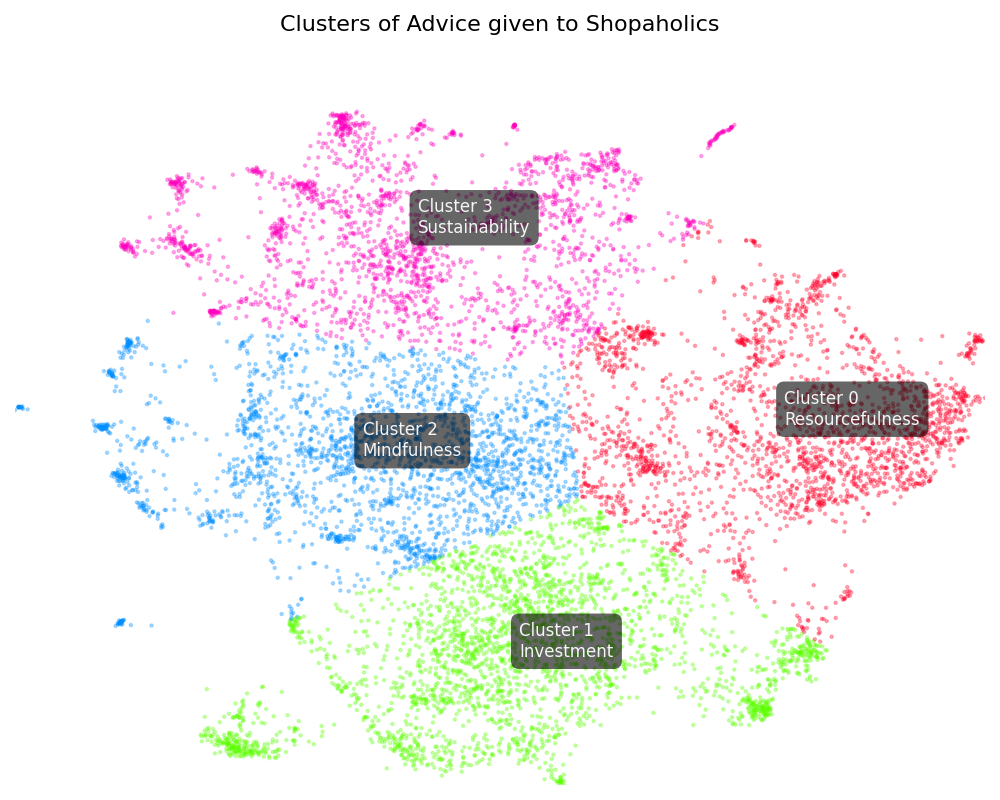

In [67]:
print(df['cluster'].unique())
# embeddings_used = embeddings[:, :2]
embeddings_used = embeddings_2d
# visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(embeddings_used[:, 0], embeddings_used[:, 1], c=df['cluster'], cmap='gist_rainbow', s=5, alpha=0.3)
ax.set_title("Clusters of Advice given to Shopaholics", fontsize=16)
crs = cursor(ax, hover=True, highlight=True)

# background color white
crs.connect("add", lambda sel: select_annotation(sel, df))

# plot the cluster centers

# ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50, alpha=0.5, marker='x')
# _____________________________CLUSTER THEMES_____________________________
# add cluster themes
for cluster, theme in cluster_themes.items():
    # find the centroid of the cluster
    cluster_center = np.mean(embeddings_used[df['cluster'] == cluster], axis=0)
    # color should be glowing
    ax.text(cluster_center[0], cluster_center[1], f"Cluster {cluster}\n{theme}", fontsize=12, color='#F5F5F5', bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.5'))
# _____________________________CLUSTER THEMES_____________________________

# ax.set_xlabel("Pricipal Component 1")
# ax.set_ylabel("Principal Component 2")



# remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# set face color to white

# zoom in to max and min
ax.set_xlim([embeddings_used[:, 0].min(), embeddings_used[:, 0].max()])
ax.set_ylim([embeddings_used[:, 1].min(), embeddings_used[:, 1].max() + 1])

# make plot wider
plt.tight_layout()

# save the plot with high dpi
plt.savefig(f"{LOCATION_PROCESSED}/kmeans_clusters_comments.png", dpi=500)

plt.show()

In [35]:
import csv
# Select 200 comments from cluster 2 and save them to a file for manual inspection.
cluster = 2
cluster_df = df[df['cluster'] == cluster]
# Show length of cluster_df
sample_df = cluster_df.sample(200)

sample_df.to_csv(f"{LOCATION_PROCESSED}/cluster_{cluster}_comments_sample_200_1x.csv", index=False)

In [15]:
import csv
# Select 200 comments from cluster 2 and save them to a file for manual inspection.
cluster = 2
cluster_df = df[df['cluster'] == cluster]

first_sample_df = pd.read_csv(f"{LOCATION_PROCESSED}/cluster_{cluster}_comments_sample_200_1x.csv")

# Remove the first sample from cluster_df
cluster_df = cluster_df[~cluster_df['id'].isin(first_sample_df['id'])]

# Show length of cluster_df
sample_df = cluster_df.sample(200)

sample_df.to_csv(f"{LOCATION_PROCESSED}/cluster_{cluster}_comments_sample_200_2x.csv", index=False)